In [51]:
%matplotlib notebook
import sys
sys.path.append('train_eval')
sys.path.append('preprocess')
from preprocess_blender import *
from IPython.display import Image, display
import torch

In [52]:
import torch
import torch.nn as nn
import math
from utils import group_points_2

nstates_plus_1 = [64,64,128]
nstates_plus_2 = [128,128,256]
nstates_plus_3 = [256,512,1024,1024,512]

class PointNet_Plus(nn.Module):
    def __init__(self):
        super(PointNet_Plus, self).__init__()
        self.num_outputs = 26
        self.knn_K = 64
        self.ball_radius2 = 0.04
        self.sample_num_level1 = 512
        self.sample_num_level2 = 128
        self.INPUT_FEATURE_NUM = 6
        
        self.netR_1 = nn.Sequential(
            # B*INPUT_FEATURE_NUM*sample_num_level1*knn_K
            nn.Conv2d(self.INPUT_FEATURE_NUM, nstates_plus_1[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[0]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[0], nstates_plus_1[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[1]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[1], nstates_plus_1[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[2]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level1*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*128*sample_num_level1*1
        )
        
        self.netR_2 = nn.Sequential(
            # B*131*sample_num_level2*knn_K
            nn.Conv2d(3+nstates_plus_1[2], nstates_plus_2[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[0]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[0], nstates_plus_2[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[1]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[1], nstates_plus_2[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[2]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*256*sample_num_level2*1
        )
        
        self.netR_3 = nn.Sequential(
            # B*259*sample_num_level2*1
            nn.Conv2d(3+nstates_plus_2[2], nstates_plus_3[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[0]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[0], nstates_plus_3[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[1]),
            nn.ReLU(inplace=True),
            # B*512*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[1], nstates_plus_3[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[2]),
            nn.ReLU(inplace=True),
            # B*1024*sample_num_level2*1
            nn.MaxPool2d((self.sample_num_level2,1),stride=1),
            # B*1024*1*1
        )
        
        self.netR_FC = nn.Sequential(
            # B*1024
            nn.Linear(nstates_plus_3[2], nstates_plus_3[3]),
            nn.BatchNorm1d(nstates_plus_3[3]),
            nn.ReLU(inplace=True),
            # B*1024
            nn.Linear(nstates_plus_3[3], nstates_plus_3[4]),
            nn.BatchNorm1d(nstates_plus_3[4]),
            nn.ReLU(inplace=True),
            # B*512
            nn.Linear(nstates_plus_3[4], self.num_outputs),
            # B*num_outputs
        )
    def forward(self, x, y):
        # x: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, y: B*3*sample_num_level1*1
        x = self.netR_1(x)
        # B*128*sample_num_level1*1
        x = torch.cat((y, x),1).squeeze(-1)
        # B*(3+128)*sample_num_level1
        
        inputs_level2, inputs_level2_center = group_points_2(x, self.sample_num_level1, self.sample_num_level2, self.knn_K, self.ball_radius2)
        # B*131*sample_num_level2*knn_K, B*3*sample_num_level2*1
        
        # B*131*sample_num_level2*knn_K
        x = self.netR_2(inputs_level2)
        # B*256*sample_num_level2*1
        x = torch.cat((inputs_level2_center, x),1)
        # B*259*sample_num_level2*1
        
        x = self.netR_3(x)
        # B*1024*1*1
        x = x.view(-1,nstates_plus_3[2])
        # B*1024
        x = self.netR_FC(x)
        # B*num_outputs
        
        return x

In [53]:
def group_points(points):
    sample_num_level1 = 512
    sample_num_level2 = 128
    ball_radius       = 0.015
    ball_radius2      = 0.04
    SAMPLE_NUM        = 1024
    knn_K             = 64
    INPUT_FEATURE_NUM = 6
    # group points using knn and ball query
    # points: B * 1024 * 6
    cur_train_size = len(points)
    inputs1_diff = points[:,:,0:3].transpose(1,2).unsqueeze(1).expand(cur_train_size,sample_num_level1,3, SAMPLE_NUM) \
                 - points[:,0:sample_num_level1,0:3].unsqueeze(-1).expand(cur_train_size,sample_num_level1,3,SAMPLE_NUM)# B * 512 * 3 * 1024
    inputs1_diff = torch.mul(inputs1_diff, inputs1_diff)    # B * 512 * 3 * 1024
    inputs1_diff = inputs1_diff.sum(2)                      # B * 512 * 1024
    dists, inputs1_idx = torch.topk(inputs1_diff, knn_K, 2, largest=False, sorted=False)  # dists: B * 512 * 64; inputs1_idx: B * 512 * 64
        
    # ball query
    invalid_map = dists.gt(ball_radius) # B * 512 * 64
    for jj in range(sample_num_level1):
        inputs1_idx[:,jj,:][invalid_map[:,jj,:]] = jj
        
    idx_group_l1_long = inputs1_idx.view(cur_train_size,sample_num_level1*knn_K,1).expand(cur_train_size,sample_num_level1*knn_K,INPUT_FEATURE_NUM)
    inputs_level1 = points.gather(1,idx_group_l1_long).view(cur_train_size,sample_num_level1,knn_K,INPUT_FEATURE_NUM) # B*512*64*6

    inputs_level1_center = points[:,0:sample_num_level1,0:3].unsqueeze(2)       # B*512*1*3
    inputs_level1[:,:,:,0:3] = inputs_level1[:,:,:,0:3] - inputs_level1_center.expand(cur_train_size,sample_num_level1,knn_K,3)
    inputs_level1 = inputs_level1.unsqueeze(1).transpose(1,4).squeeze(4)  # B*6*512*64
    inputs_level1_center = inputs_level1_center.contiguous().view(-1,1,sample_num_level1,3).transpose(1,3)  # B*3*512*1
    return inputs_level1, inputs_level1_center
    #inputs_level1: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, inputs_level1_center: B*3*sample_num_level1*1

In [123]:
data_root = '/Volumes/AndrewJayZhou/Dataset/FootPoseDepth/syn/v2'
depth_map = os.path.join(data_root, '0000', '0000.exr')
gt        = os.path.join(data_root, '0000', '0000_joint_pos.txt')
pc, coeff, max_bb3d_len, offset, jnt_xyz_normalized = preprocess(depth_map, gt)
point_cloud = torch.from_numpy(pc.reshape((1,1024,6))).float()

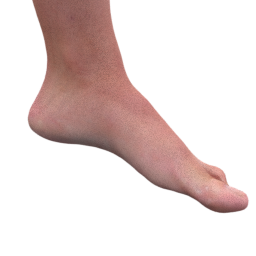

In [124]:
display(Image(filename=os.path.join(data_root, '0000', '0000.png')))

[[-0.40123635 -0.06311135  0.00983536]
 [-0.2856231  -0.01463819 -0.00475391]
 [-0.39376646 -0.05245954  0.05585999]
 [-0.29692699 -0.02195376  0.05917928]
 [-0.37506463 -0.05136856  0.10831015]
 [-0.28457386 -0.01993431  0.10260521]
 [-0.35044169 -0.04097277  0.14679875]
 [-0.25808154 -0.00909559  0.14598358]
 [-0.30237453 -0.01790142  0.18650534]
 [-0.23162037  0.00705881  0.18921577]
 [ 0.13097356 -0.00928699 -0.03775346]
 [ 0.18995023 -0.01042703  0.13411056]
 [ 0.21108056  0.22084962  0.07598746]]


<IPython.core.display.Javascript object>


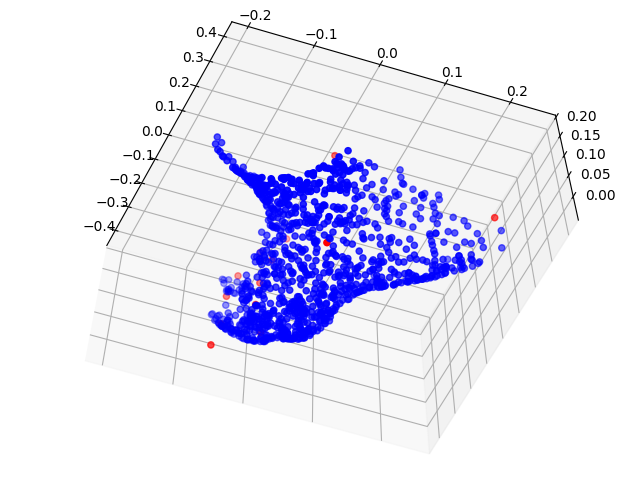

In [125]:
print(jnt_xyz_normalized)
plot(pc,jnt_xyz_normalized)

In [143]:
# load net
netR = PointNet_Plus()
weight_path = 'results/iter_001/netR_5.pth'
netR.load_state_dict(torch.load(weight_path, map_location='cpu'))
netR.eval()

# feed forward
inputs_level1, inputs_level1_center = group_points(point_cloud)
estimation = netR(inputs_level1, inputs_level1_center)



In [144]:
PCA_data_path = '/Volumes/AndrewJayZhou/Dev/HandPointNet/data/blender_v2'
PCA_coeff_mat = np.load(os.path.join(PCA_data_path, 'PCA_coeff.npy'))

PCA_coeff = torch.from_numpy(PCA_coeff_mat[:, 0:26].astype(np.float32))
PCA_mean_mat = np.load(os.path.join(PCA_data_path, 'PCA_mean_xyz.npy'))
PCA_mean = torch.from_numpy(PCA_mean_mat.astype(np.float32))

PCA_coeff = PCA_coeff.transpose(0, 1)
PCA_mean = PCA_mean.view(1,-1)

<IPython.core.display.Javascript object>


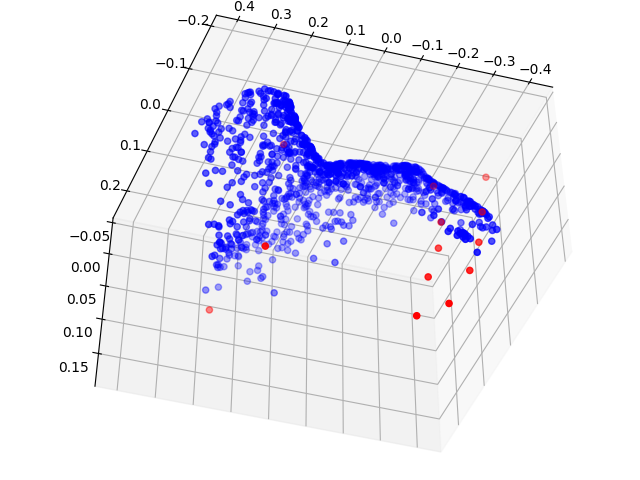

In [145]:
outputs_xyz = PCA_mean.expand(1, PCA_mean.size(1))
outputs_xyz = torch.addmm(outputs_xyz, estimation.data, PCA_coeff)
outputs_xyz = outputs_xyz.numpy().reshape((13,3))

plot(pc, outputs_xyz)